In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OMP_WAIT_POLICY"] = "PASSIVE"

import torch
torch.set_num_threads(1)

import colbert.warp.setup

from colbert.warp.config import WARPRunConfig
from colbert.warp.searcher import WARPSearcher
from colbert.warp.data.queries import WARPQueries

from colbert.warp.openvino_model import (
    XTROpenVinoConfig,
)

from colbert.warp.onnx_model import (
    XTROnnxConfig,
    XTROnnxQuantization
)

from colbert.utils.tracker import ExecutionTracker

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


#> Running WARP Setup Code.


In [2]:
# optim = XTROpenVinoConfig()


optim = XTROnnxConfig(quantization=XTROnnxQuantization.QUANTIZED_QATTENTION)

config = WARPRunConfig(
    nranks=4,
    dataset="lotte",
    collection="lifestyle",
    type_="search",
    datasplit="test",
    nbits=4,
    k=100,
    optim=optim
)
searcher = WARPSearcher(config)

queries = WARPQueries(config)

[Aug 12, 05:58:54] #> Loading collection...
0M 
#> Loading XTR ONNX model from '/lfs/1/scheerer/models/xtr.v=16.batch=1.QUANTIZED_QATTENTION.onnx' (418.76MB)


/future/u/scheerer/miniconda3/envs/colbert/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[Aug 12, 05:58:56] #> Loading buckets...
[Aug 12, 05:58:56] #> Loading codec...
[Aug 12, 05:58:57] Loading segmented_lookup_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Aug 12, 05:58:57] #> Loading repacked residuals...
[Aug 12, 05:58:58] Loading precompute_topk_centroids_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Aug 12, 05:58:59] Loading decompress_centroid_embeds_strided_repacked_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Aug 12, 05:58:59] Loading compute_candidate_scores_cpp extension (set WARP_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...
[Aug 12, 05:59:00] #> Loading the queries from /lfs/1/scheerer/datasets/lotte/lotte/lifestyle/test/questions.search.tsv ...
[Aug 12, 05:59:00] #> Got 661 queries. All QIDs are unique.



In [3]:
tracker = ExecutionTracker(name="XTR/WARP", steps=["Query Encoding", "Candidate Generation", "top-k Precompute",
                                                   "Decompression", "Lookup", "Build Matrix"])
ranking = searcher.search_all(queries, k=5, batched=False, tracker=tracker)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 661/661 [00:34<00:00, 19.12it/s]


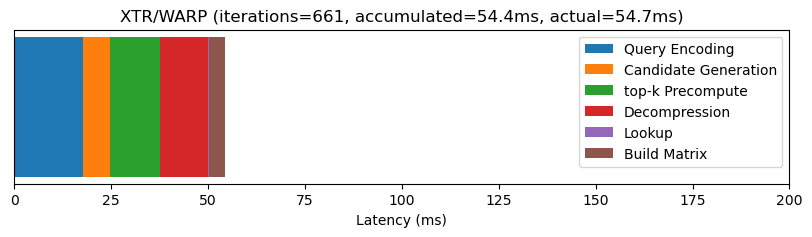

In [5]:
tracker.display(bound=200)

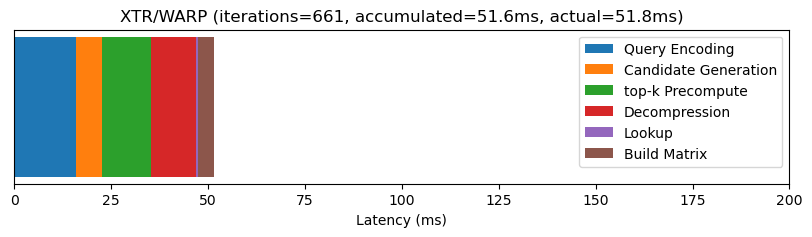

In [4]:
tracker.display(bound=200)

{'Success@5': 82.60211800302571}


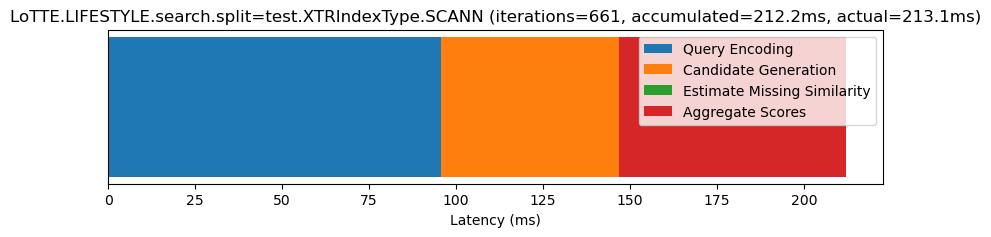

{'Success@5': 83.50983358547656}


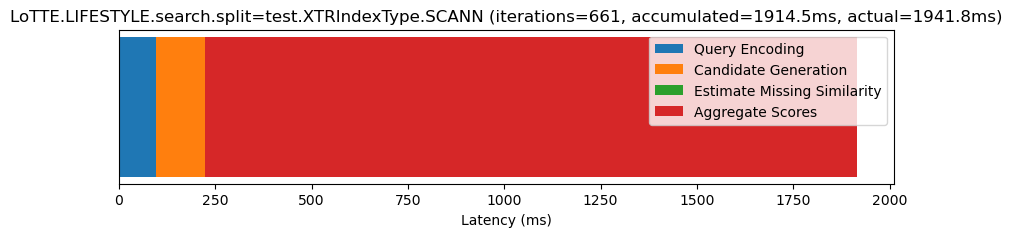

{'Success@5': 77.00453857791226}


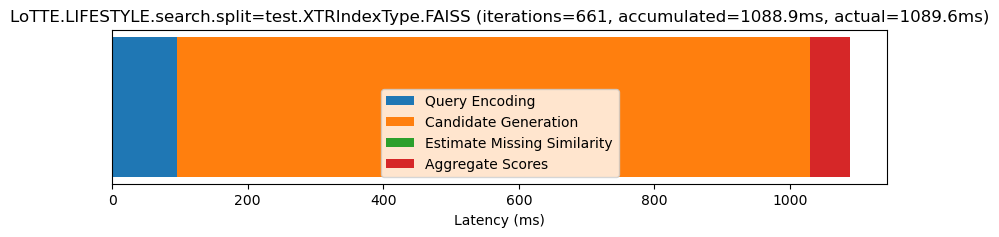

{'Success@5': 73.07110438729198}


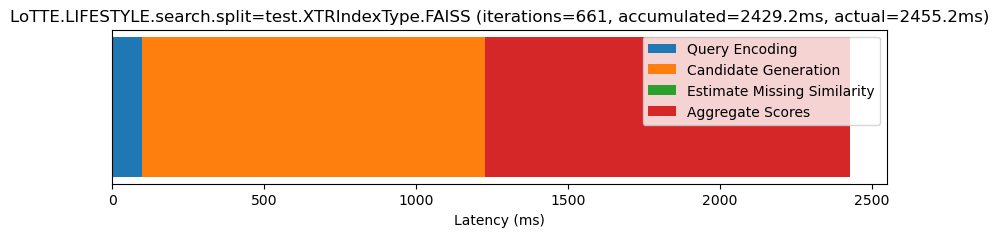

In [14]:
from colbert.utils.tracker import ExecutionTracker
import json

with open("xtr-eval/results.json", "r") as file:
    results = json.load(file)

for entry in results:
    tracker = ExecutionTracker.from_dict(entry["tracker"])
    print(entry["metrics"])
    tracker.display()